<a href="https://colab.research.google.com/github/a8252525/detectron2_example_PCBdata/blob/master/PCBdata_fasterRCNN_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You can check [here](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md) to get needed environment, but you don't need to worry it in colab.

In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
     |████████████████████████████████| 276kB 9.2MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=419b78aee32c249eac7cadc2578976e9e6d412376cedd4a1000e77a265842ea2
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-gi1t56xu
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-gi1t56xu
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-lin

In [5]:
!git clone https://github.com/tangsanli5201/DeepPCB
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Cloning into 'DeepPCB'...
remote: Enumerating objects: 4753, done.
remote: Total 4753 (delta 0), reused 0 (delta 0), pack-reused 4753
Receiving objects: 100% (4753/4753), 85.81 MiB | 30.41 MiB/s, done.
Resolving deltas: 100% (191/191), done.
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 624kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post200513-cp36-none-any.whl size=40893 sha256=0373e4f0343a15e49d5321d0cfb89ace9bf2bed8fa4930bc85806b65b126a101
  Stored in directory: /root/.cache/pip/wheels/a2/f6/77/551770c4b8cd75e9335cd0acf59c08d60a8684048b19da6702
Successfully built fvcore


In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [0]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from matplotlib.pyplot import imshow
from PIL import Image
import IPython
def cv2_imshow(img):
    img = img[:,:,[2,1,0]]
    img = Image.fromarray(img)
    plt.figure(figsize=(20, 20))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

We have to take the data out from the .txt file.

In [9]:
import csv
train, test = [],[]
def take_path(x,d):
    with open(d) as t:
        #print(t.read())
        #print(type(csv.reader(t)))
        tmp = csv.reader(t,delimiter=' ')
        for i in tmp:
            x.append(i)
        for ele in x:
            ele[0] = './DeepPCB/PCBData/'+ele[0][:-4]+'_test.jpg'
            ele[1] = './DeepPCB/PCBData/'+ele[1]

take_path(test,'./DeepPCB/PCBData/test.txt')
print(test[:2])
take_path(train,'./DeepPCB/PCBData/trainval.txt')
print(train[:2])


[['./DeepPCB/PCBData/group20085/20085/20085291_test.jpg', './DeepPCB/PCBData/group20085/20085_not/20085291.txt'], ['./DeepPCB/PCBData/group20085/20085/20085292_test.jpg', './DeepPCB/PCBData/group20085/20085_not/20085292.txt']]
[['./DeepPCB/PCBData/group20085/20085/20085000_test.jpg', './DeepPCB/PCBData/group20085/20085_not/20085000.txt'], ['./DeepPCB/PCBData/group20085/20085/20085001_test.jpg', './DeepPCB/PCBData/group20085/20085_not/20085001.txt']]


In [10]:
height, width = cv2.imread(test[0][0]).shape[:2]
print(height, width)


640 640


# New Section

In [0]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#DatasetCatalog.clear()
#If you want to clear the data you registered, uncomment the upper line.

def get_PCB_dict(data_list):
    dataset_dicts = []
    
    for i,path in enumerate(data_list):
        filename = path[0]
        height, width = cv2.imread(filename).shape[:2]
        record = {}
        record['file_name'] = filename
        record['image_id'] = i
        record['height']= height
        record['width']= width
        
        
        objs = []
        with open(path[1]) as t:
            lines = t.readlines()
            for line in lines:
                if line[-1]=="\n":
                  box = line[:-1].split(' ')
                else:
                  box = line.split(' ')


                boxes = list(map(float,[box[0],box[1],box[2],box[3]]))
                category = int(box[4])

                obj = {
                    "bbox": boxes,
                    "bbox_mode": BoxMode.XYXY_ABS,
                    #"segmentation": [poly], To draw a line, along to ballon
                    #you will need this for mask RCNN
                    "category_id": category-1,
                    "iscrowd": 0
                }
                objs.append(obj)
            record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts #list of dicts

In [0]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d,x in [("train",train), ("test",test)]:
    DatasetCatalog.register("PCB_" + d, lambda x=x: get_PCB_dict(x))
    MetadataCatalog.get("PCB_" + d).set(thing_classes=["open", "short", "mousebite", "spur", "copper", "pin-hole"],thing_colors=[(255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,0,255),(0,255,255)])
    #I set the colors, but it's no use. Retry after training.
PCB_metadata = MetadataCatalog.get("PCB_train")

In [13]:
#check dataset
print(type(PCB_metadata))
MetadataCatalog.get("PCB_test")

<class 'detectron2.data.catalog.Metadata'>


Metadata(name='PCB_test', thing_classes=['open', 'short', 'mousebite', 'spur', 'copper', 'pin-hole'], thing_colors=[(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255)])

Get all the data and check the content inside

In [0]:
dataset_dicts = get_PCB_dict(train)

In [15]:
print(dataset_dicts[0])
print(dataset_dicts[1])

{'file_name': './DeepPCB/PCBData/group20085/20085/20085000_test.jpg', 'image_id': 0, 'height': 640, 'width': 640, 'annotations': [{'bbox': [409.0, 394.0, 435.0, 422.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2, 'iscrowd': 0}, {'bbox': [275.0, 383.0, 319.0, 417.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2, 'iscrowd': 0}, {'bbox': [8.0, 163.0, 36.0, 191.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 3, 'iscrowd': 0}, {'bbox': [244.0, 151.0, 270.0, 182.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 4, 'iscrowd': 0}, {'bbox': [338.0, 519.0, 364.0, 543.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 5, 'iscrowd': 0}, {'bbox': [476.0, 460.0, 502.0, 481.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 3, 'iscrowd': 0}]}
{'file_name': './DeepPCB/PCBData/group20085/20085/20085001_test.jpg', 'image_id': 1, 'height': 640, 'width': 640, 'annotations': [{'bbox': [335.0, 208.0, 364.0, 233.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2, '

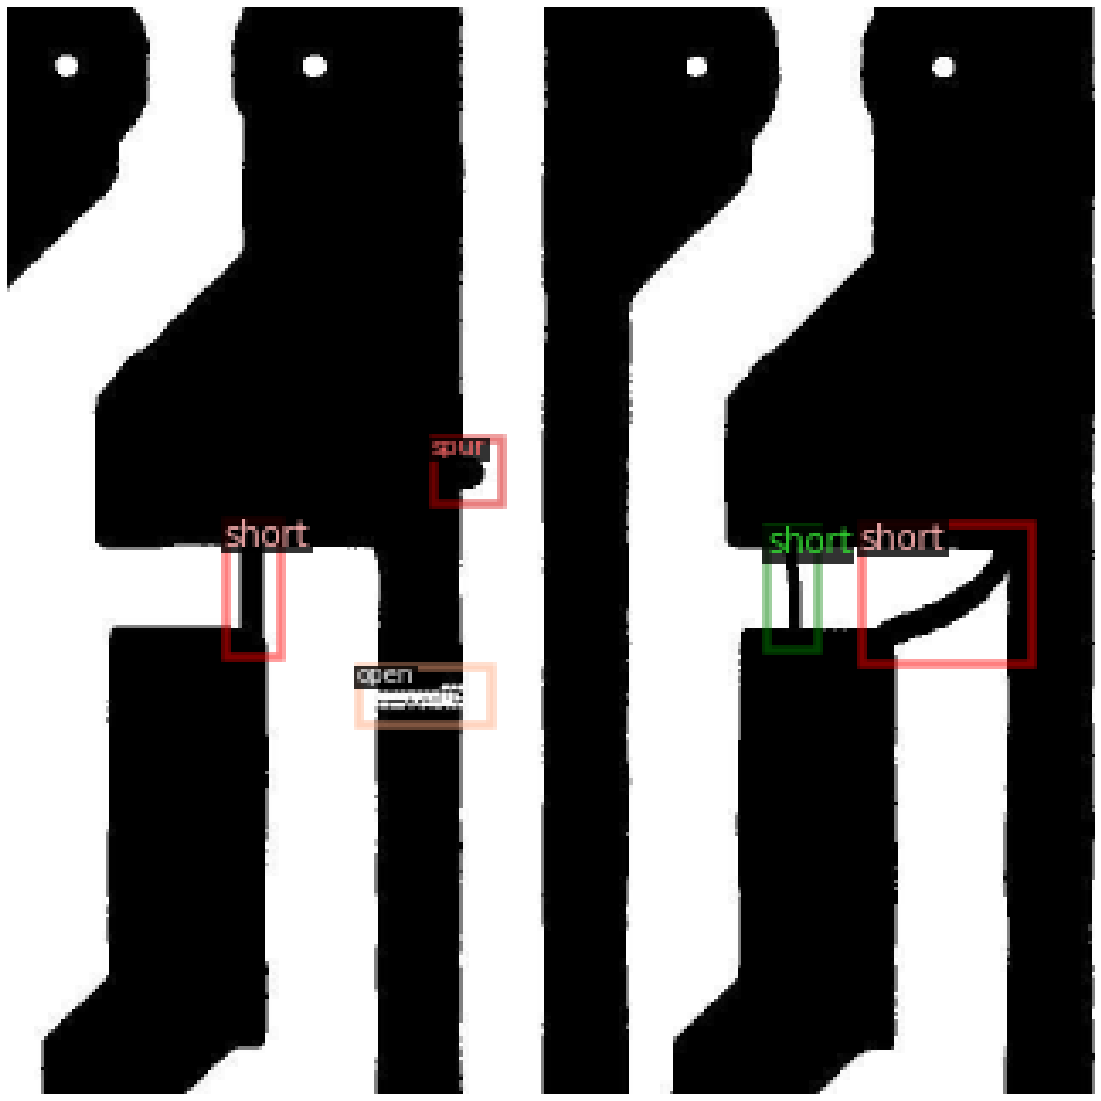

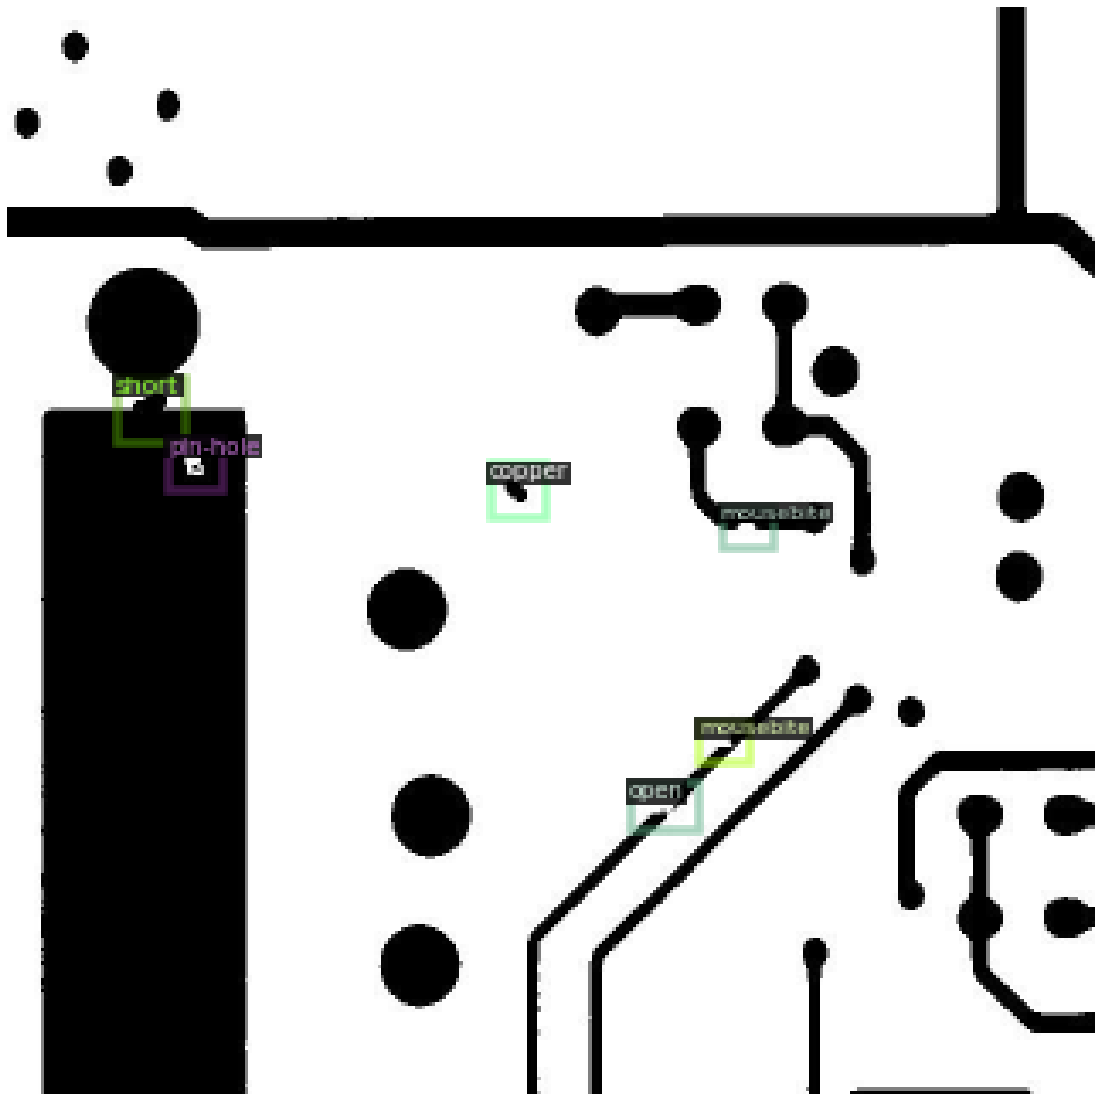

In [16]:
for d in random.sample(dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=PCB_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [17]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("PCB_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 0
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 3000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4096   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()
#It will train about 20 minutes in colab.

[05/27 02:50:35 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:17, 9.52MB/s]                           
'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (7, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (7,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (24, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (24,) in the model! Skipped.


[05/27 02:51:03 d2.engine.train_loop]: Starting training from iteration 0
[05/27 02:51:10 d2.utils.events]:  eta: 0:17:06  iter: 19  total_loss: 2.453  loss_cls: 1.809  loss_box_reg: 0.034  loss_rpn_cls: 0.401  loss_rpn_loc: 0.158  time: 0.3448  data_time: 0.0414  lr: 0.000005  max_mem: 1828M
[05/27 02:51:17 d2.utils.events]:  eta: 0:17:11  iter: 39  total_loss: 2.209  loss_cls: 1.622  loss_box_reg: 0.036  loss_rpn_cls: 0.429  loss_rpn_loc: 0.140  time: 0.3460  data_time: 0.0382  lr: 0.000010  max_mem: 1828M
[05/27 02:51:24 d2.utils.events]:  eta: 0:16:49  iter: 59  total_loss: 1.727  loss_cls: 1.303  loss_box_reg: 0.042  loss_rpn_cls: 0.287  loss_rpn_loc: 0.125  time: 0.3442  data_time: 0.0391  lr: 0.000015  max_mem: 1828M
[05/27 02:51:31 d2.utils.events]:  eta: 0:16:46  iter: 79  total_loss: 1.331  loss_cls: 0.904  loss_box_reg: 0.049  loss_rpn_cls: 0.238  loss_rpn_loc: 0.130  time: 0.3445  data_time: 0.0396  lr: 0.000020  max_mem: 1828M
[05/27 02:51:38 d2.utils.events]:  eta: 0:16:4

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("PCB_test", )
predictor = DefaultPredictor(cfg)

In [0]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_PCB_dict(test)

tensor([0, 3, 5, 2, 1], device='cuda:0')
Boxes(tensor([[255.8279, 246.0494, 292.5704, 283.2453],
        [432.6134, 241.0275, 460.0805, 267.9203],
        [323.7750, 371.5912, 354.2988, 396.6692],
        [316.3111, 185.9612, 344.8200, 214.2473],
        [208.1844, 166.5739, 250.3002, 195.4234]], device='cuda:0'))


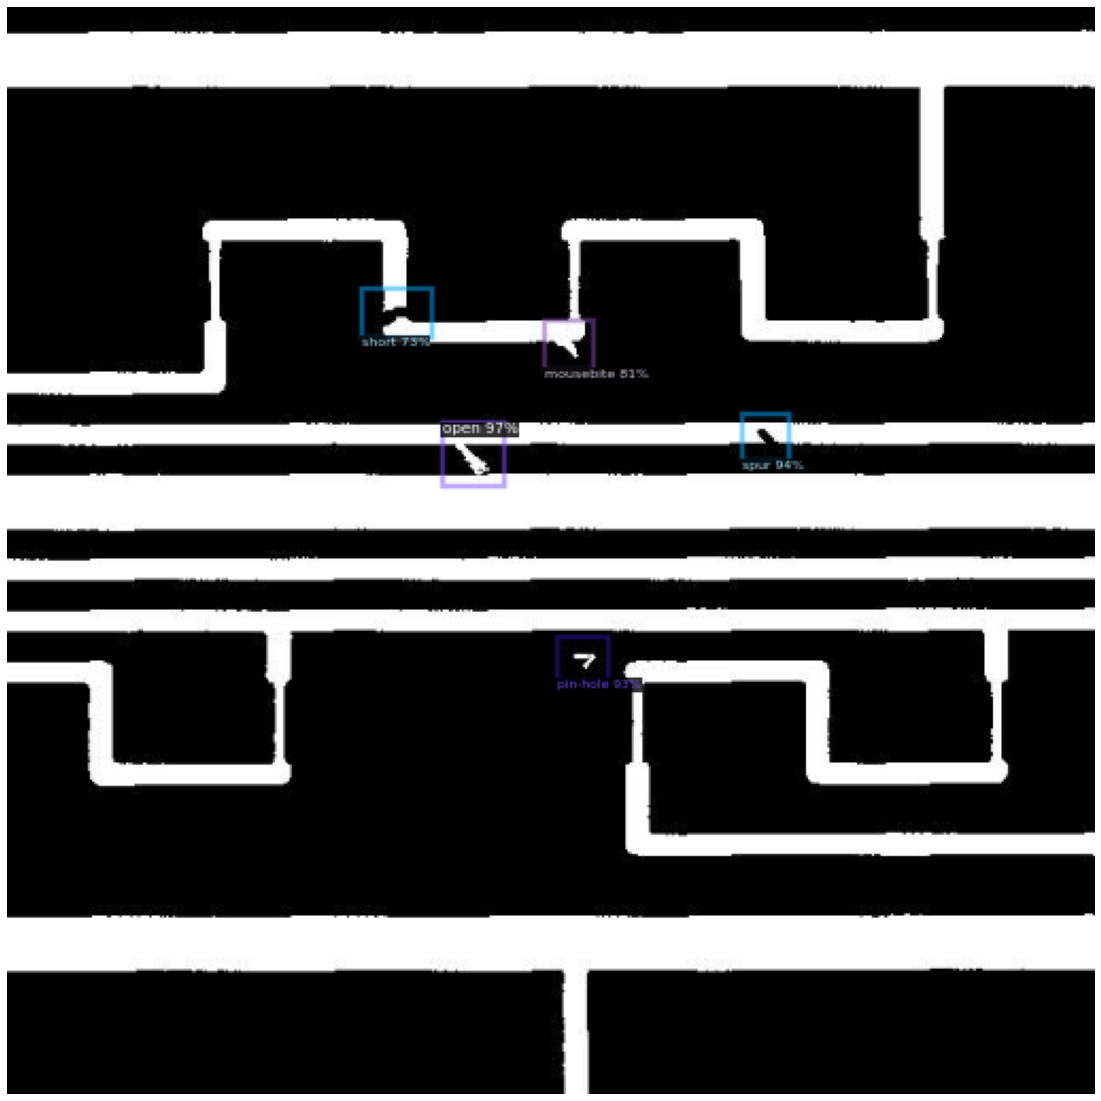

tensor([5, 4, 4, 3, 0, 5, 2, 3], device='cuda:0')
Boxes(tensor([[567.8026, 322.0833, 596.8983, 345.6652],
        [ 73.9130, 197.2079, 116.1199, 227.7167],
        [500.9328, 215.7404, 533.4565, 248.9158],
        [506.4293, 440.4582, 529.5654, 467.6434],
        [188.4805, 401.0225, 225.7951, 428.8748],
        [257.5113, 241.2941, 286.5542, 271.3348],
        [244.3054, 341.3608, 275.6966, 367.1490],
        [468.6176, 257.3161, 498.1739, 285.8427]], device='cuda:0'))


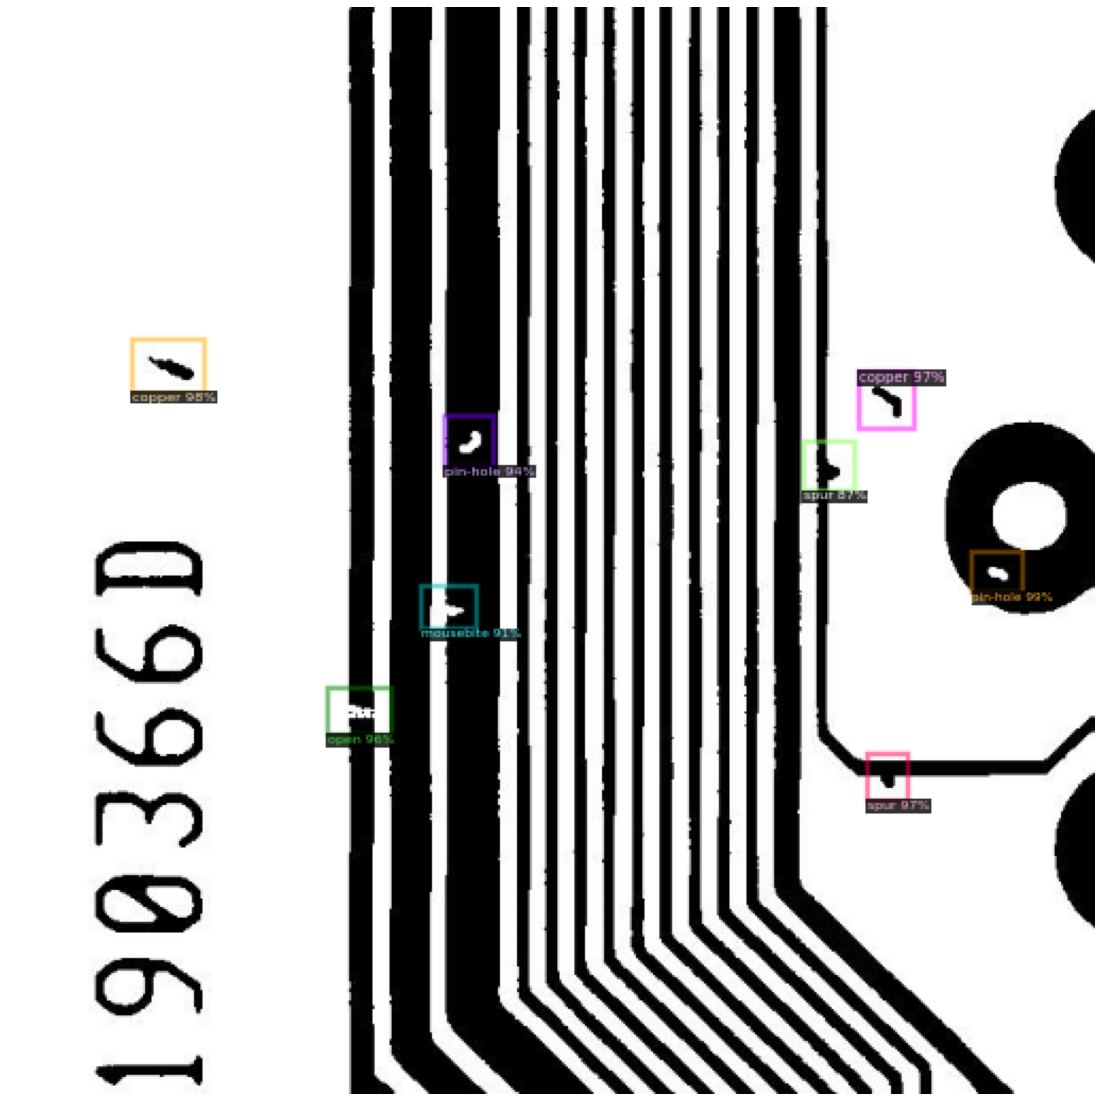

tensor([1, 4, 0, 0, 0, 0, 1], device='cuda:0')
Boxes(tensor([[491.1194, 335.8253, 546.5974, 360.1077],
        [242.5737,  22.9782, 285.3928,  67.3458],
        [115.6752, 251.4884, 184.7003, 282.8336],
        [553.9138, 260.9890, 576.3972, 286.2153],
        [415.0030, 414.1444, 443.3676, 444.7610],
        [375.5686, 464.5266, 452.6157, 540.4453],
        [596.9073, 168.4800, 639.6799, 191.3669]], device='cuda:0'))


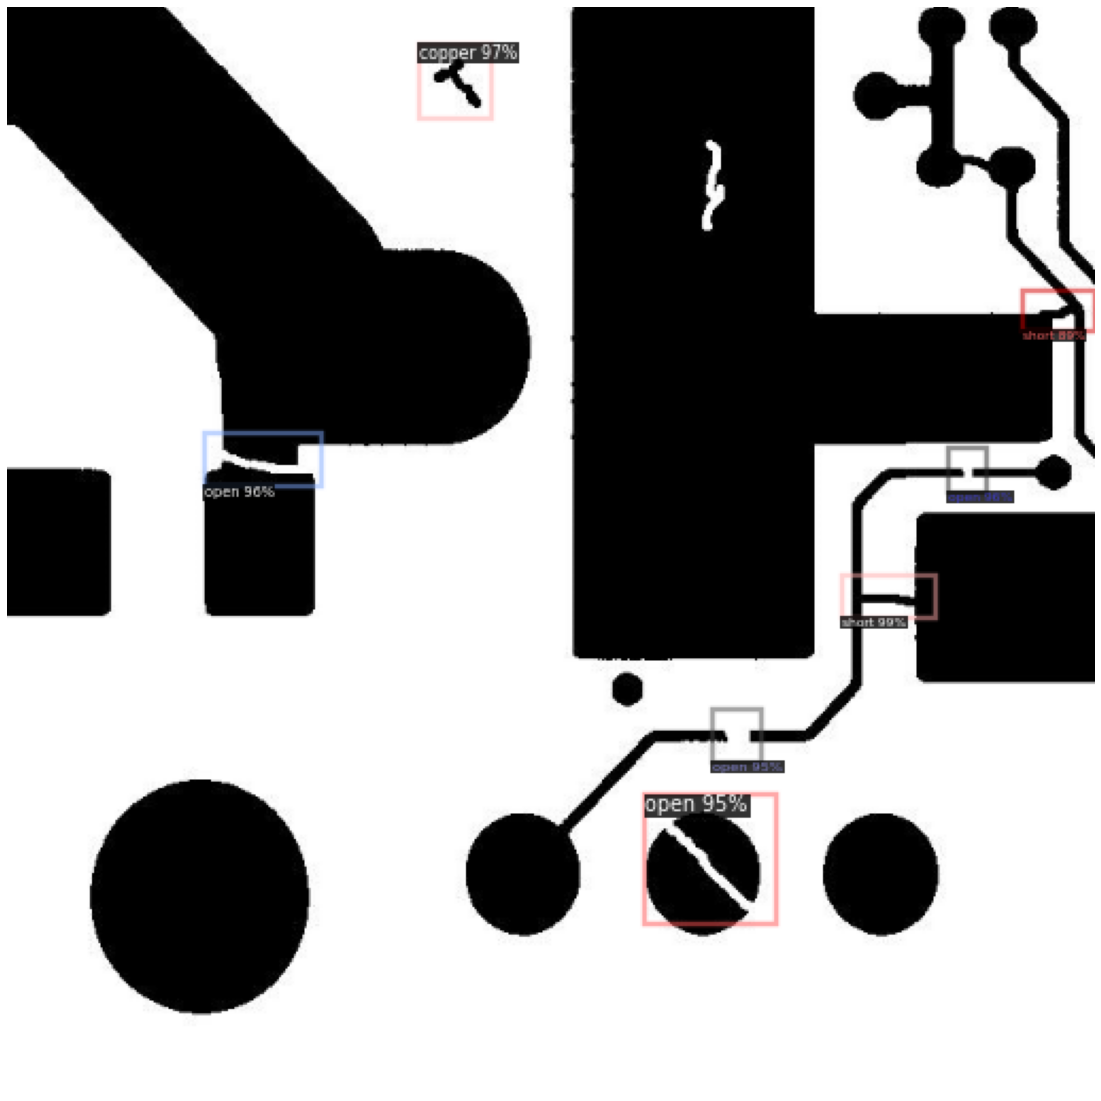

In [20]:
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im,
                   metadata=PCB_metadata, 
                   scale=0.8,
                   instance_mode =  ColorMode.IMAGE
        )
                   # remove the colors of unsegmented pixels
    print(outputs['instances'].pred_classes)
    print(outputs["instances"].pred_boxes)

    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image())

In [21]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, LVISEvaluator
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("PCB_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "PCB_test")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [05/27 03:10:17 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'PCB_test'. Trying to convert it to COCO format ...
[05/27 03:10:17 d2.data.datasets.coco]: Converting annotations of dataset 'PCB_test' to COCO format ...)
[05/27 03:10:19 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[05/27 03:10:19 d2.data.datasets.coco]: Conversion finished, #images: 500, #annotations: 3140
[05/27 03:10:19 d2.data.datasets.coco]: Caching COCO format annotations at './output/PCB_test_coco_format.json' ...
[05/27 03:10:20 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    open    | 659          |   short    | 478          | mousebite  | 586          |
|    spur    | 483          |   copper   | 464          |  pin-hole  | 470          |
|            |        

OrderedDict([('bbox',
              {'AP': 55.84595865048199,
               'AP-copper': 61.8401222732856,
               'AP-mousebite': 52.48843858056929,
               'AP-open': 54.66710485944941,
               'AP-pin-hole': 65.8955014943486,
               'AP-short': 45.78744688856003,
               'AP-spur': 54.397137806679055,
               'AP50': 94.28747093385844,
               'AP75': 63.71251333635415,
               'APl': 69.99999999999999,
               'APm': 58.926888599749084,
               'APs': 52.24240990474615})])